In [1]:
from tvb.simulator.lab import *

In [2]:
import numpy as np
import pandas as pd
import pylab as plt

### From the file morris_lecar_modified.py I import the Morris Lecar model

In [3]:
from tvb.contrib.simulator.models.morris_lecar_modified import *

#### Rinzel and Ermentrout parameters for figures 7.1-7.3:

$V_1=-1.2,\enspace V_2=18,\enspace V_3=2,\enspace V_4=30,\enspace g_{Ca}=4.4,\enspace g_K=8.0,\\ g_L=2,\enspace V_K=-84,\enspace V_L=-60,\enspace V_{Ca}=120,\enspace C=20 \; μF/cm^2,\enspace \phi=0.04$

Parameters for the Morris Lecar model (cf. Rinzel, J. and Ermentrout, B. 1998, Appendix A).


In [4]:
def ML_params():
    ML_params = dict(variables_of_interest=['V','N'],
                  I=np.array([0]), V1=np.array([-1.2]), V2=np.array([18]), V3=np.array([2]), 
                  V4=np.array([30]), gCa=np.array([4.4]), gK=np.array([8.0]), gL=np.array([2]), 
                  VK=np.array([-84]), VL=np.array([-60]), VCa=np.array([120]), C=np.array([20]), 
                  lambda_Nbar=np.array([0.04]))
    return ML_params

### Define the function ML_sim

The function takes as arguments the parameters we want to manipulate: model, integration time, stimulus characteristics and simulation length. Finally, the function returns time and data.

In `CONNECTIVITY` I use a simple connectivity with a single node (single neuron).

In `SIMULATION COMPONENTS` I set the integration method and the monitor for the simulation.

In `STIMULUS` I configure the input.

In `SIMULATION` I configure the simulation.

In `RESULTS` I run the simulation and collect the data by separating the times and the data of the state variables V and N.

In [5]:
def ML_sim(local_model = MorrisLecarMod(**ML_params()),dt=0.1, 
           stimulus_onset = 1000., stimulus_T = 1000, 
           stimulus_tau = 10, stimulus_weight = 1, 
           stimulus_amp = 50, sim_length = 1e3,
           V_Init=np.random.uniform(-70,50),
           W_Init=np.random.uniform(-0.2,0.8)):

    # CONNECTIVITY:
    conn = connectivity.Connectivity(centres=np.array(1)) 
    conn.motif_linear_directed(number_of_regions=1)
    conn.configure()
    
    # SIMULATION COMPONENTS:
    integ = integrators.RungeKutta4thOrderDeterministic(dt=dt)
    mon = (monitors.Raw(),)
    initial_data = np.zeros((1, 2, conn.number_of_regions, 1))
    initial_data[:,0,:,0]=V_Init
    initial_data[:,1,:,0]=W_Init
    
    
    # STIMULUS:
    weighting = numpy.zeros((conn.number_of_regions, )) 
    weighting[[0]] = stimulus_weight
    eqn_pt = equations.PulseTrain()
    eqn_pt.parameters['onset'] = stimulus_onset
    eqn_pt.parameters['tau'] = stimulus_tau
    eqn_pt.parameters['T'] = stimulus_T
    eqn_pt.parameters['amp'] = stimulus_amp
    stimulus = patterns.StimuliRegion(temporal=eqn_pt,
                                        connectivity=conn,
                                        weight=weighting)
    
    # SIMULATION:
    sim = simulator.Simulator(integrator = integ, connectivity = conn, model = local_model, 
                              monitors = mon, stimulus = stimulus,
                              initial_conditions = initial_data)

    sim.configure()
    
    # RESULTS:
    result = sim.run(simulation_length = sim_length)
    time = result[0][0]
    data = np.squeeze(result[0][1])
    data_V = data[:,0]
    data_W = data[:,1]
    
    return time, data, data_V, data_W    

## 1. The system has a unique rest state

#### Find the rest state
We run a simulation, starting from random initial conditions and lasting 3 s, to find the values of the resting state.

<IPython.core.display.Javascript object>


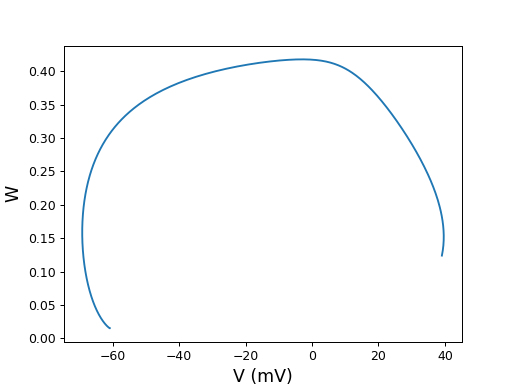

V_rest=-60.85538223230926; W_rest=0.014915024953999736


In [6]:
[time, data, data_V, data_W] = ML_sim(stimulus_amp=0,dt=0.1, sim_length=3000)
%matplotlib notebook
plt.figure()
plt.plot(data_V,data_W)
plt.xlabel('V (mV)', fontsize=14)
plt.ylabel("W", fontsize=14)
print('\033[1m' + f'V_rest={data_V[-1]}; W_rest={data_W[-1]}' + '\033[0m')

In [7]:
V_rest=data_V[-1]
W_rest=data_W[-1]

## 2. Thresholdlike behaviour for action potential generation.

#### Response ot the model to a brief current pulse
The four simulations start from the rest state ($V$≃ -61 mV, $W$≃0.015) and four different stimulation pulses of 1 ms are injected at t = 0 ms.

`SIMULATION 1`: pulse amplitude=46.15

`SIMULATION 2`: pulse amplitude=48.33 

`SIMULATION 3`: pulse amplitude=48.4 

`SIMULATION 4`: pulse amplitude=52

In [8]:
[time1, data1, data_V1, data_W1] = ML_sim(stimulus_amp=46.15, stimulus_onset=0,
                                          stimulus_tau=1, dt=0.1, sim_length=120,
                                          V_Init=V_rest,
                                          W_Init=W_rest)

[time2, data2, data_V2, data_W2] = ML_sim(stimulus_amp=48.33, stimulus_onset=0,
                                          stimulus_tau=1, dt=0.1, sim_length=120,
                                          V_Init=V_rest,
                                          W_Init=W_rest)
                                          
[time3, data3, data_V3, data_W3] = ML_sim(stimulus_amp=48.4, stimulus_onset=0,
                                          stimulus_tau=1, dt=0.1, sim_length=120,
                                          V_Init=V_rest,
                                          W_Init=W_rest)

[time4, data4, data_V4, data_W4] = ML_sim(stimulus_amp=52, stimulus_onset=0,
                                          stimulus_tau=1, dt=0.1, sim_length=120,
                                          V_Init=V_rest,
                                          W_Init=W_rest)

#### The pulses bring $V$ from the rest state to $V_0$ (dashed black line).
$V_0$ is twice under-threshold and twice over-threshold; two action potentials can be observed.
<br> The threshold is between $V$=-13.7 mV and $V$=-13.8 mV.

<IPython.core.display.Javascript object>


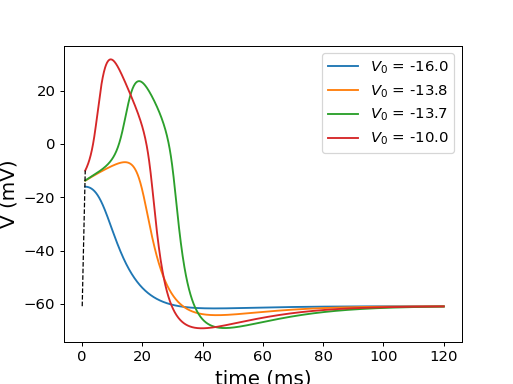

In [9]:
dt=0.1
fig, ax = plt.subplots()

#data_V[int(1/dt)]: value of V at the end of the 1 ms pulse. 
ax.plot(time1[int(1/dt):], data_V1[int(1/dt):], label=f'$V_0$ = {round(data_V1[int(1/dt)],1)}') 
ax.plot(time2[int(1/dt):], data_V2[int(1/dt):], label=f'$V_0$ = {round(data_V2[int(1/dt)],1)}')
ax.plot(time3[int(1/dt):], data_V3[int(1/dt):], label=f'$V_0$ = {round(data_V3[int(1/dt)],1)}')
ax.plot(time4[int(1/dt):], data_V4[int(1/dt):], label=f'$V_0$ = {round(data_V4[int(1/dt)],1)}')

#Displacement of V towards V_0 caused by the pulse
ax.plot(time4[:int(1/dt)+1], data_V4[:int(1/dt)+1],linestyle='--',linewidth=1, color='k') 

ax.set_xlabel('time (ms)', fontsize=16)
ax.set_ylabel('V (mV)',fontsize=16)
ax.tick_params(axis="x", labelsize=12) 
ax.tick_params(axis="y", labelsize=12) 
ax.legend(loc='best',fontsize=12)

#### Trajectories in the V-W plane.
The same responses to the brief pulse are represented in the V-W plane.
The direction of motion along the trajectories are indicated by arrowheads. <br>
Each trajectory has a unique initial point, i.e. the rest state, and the effect of the pulse, corresponding to an instantaneous depolarization, is to displace horizontally from the rest point (dashed black line) (cf. Rinzel & Ermentrout 1998).

<IPython.core.display.Javascript object>


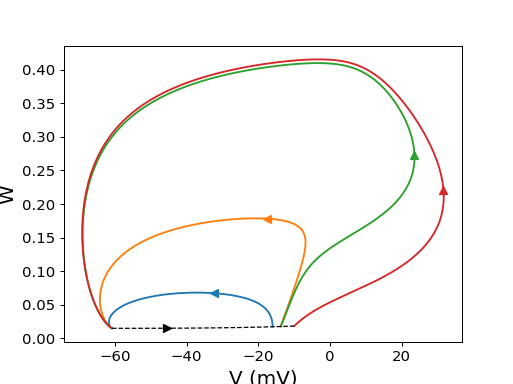

In [10]:
fig, ax = plt.subplots()

#Trajectories after pulse of 1 ms.
ax.plot(data_V1[int(1/dt):],data_W1[int(1/dt):],color='tab:blue')
ax.plot(data_V2[int(1/dt):],data_W2[int(1/dt):],color='tab:orange')
ax.plot(data_V3[int(1/dt):],data_W3[int(1/dt):],color='tab:green')
ax.plot(data_V4[int(1/dt):],data_W4[int(1/dt):],color='tab:red')

#Horizontal displacement of the trajectories caused by the pulse
ax.plot(data_V4[:int(1/dt)+1],data_W4[:int(1/dt)+1],color='k',linestyle='--',linewidth=1)

#Arrowheads indicating the direction of motion
ax.plot(data_V1[100],data_W1[100],'<',color='tab:blue') 
ax.plot(data_V2[200],data_W2[200],'<',color='tab:orange') 
ax.plot(data_V3[190],data_W3[190],'^',color='tab:green') 
ax.plot(data_V4[98],data_W4[98],'^',color='tab:red') 
ax.plot(data_V4[3],data_W4[3],'>',color='k')

ax.set_xlabel('V (mV)', fontsize=16)
ax.set_ylabel('W',fontsize=16)
ax.tick_params(axis="x", labelsize=12) 
ax.tick_params(axis="y", labelsize=12) 

#### Trajectory of the action potential

"The trajectory of an action potential shows the following features: an upstroke with rapid increase in $V$ (trajectory is moving rightward with little vertical component) and then the transient plateau with the delayed major increase in $W$, corresponding to the slower opening of $K^+$ Channels. When $W$ is large enough, the abrupt downstroke in $V$ occurs - the trajectory moves leftward, nearly horizontal, as $V$ tends toward $V_K$ . Finally, as $W$ decreases (the potassium channels close) the state point returns to rest with a slow recovery from hyperpolarization" (Rinzel, J. and Ermentrout, B. 1998). 






<IPython.core.display.Javascript object>


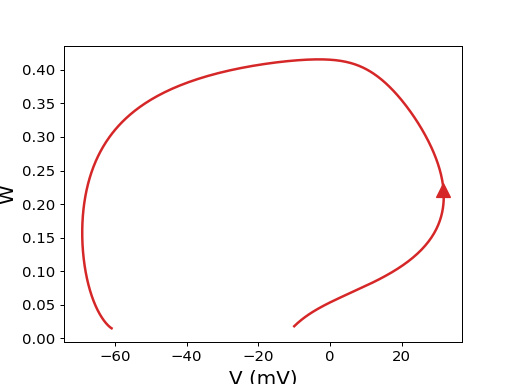

In [11]:
dt=0.1
fig, ax = plt.subplots()

#Trajectory after the 1 ms pulse.
ax.plot(data_V4[int(1/dt):],data_W4[int(1/dt):],color='tab:red',linewidth=2)

#Arrowhead indicating the direction of motion
ax.plot(data_V4[98],data_W4[98],'^',color='tab:red',markersize=11)

ax.set_xlabel('V (mV)', fontsize=16)
ax.set_ylabel('W',fontsize=16)
ax.tick_params(axis="x", labelsize=12) 
ax.tick_params(axis="y", labelsize=12)

## 3. Emergence of oscillations
With these parameters the model has a unique equilibrium point. "It is asymptotically stable, that is, for any nearby initial point the solution tends to the singular point as $t\rightarrow\infty$ [...]. As a parameters are varied, the singular point may lose stability. In our example, the rest state could then no longer be mantained and the behavior of the system would change - it may fire repetitively or tend to a different steady state (if a stable one exists). LET US CONSIDER THE EFFECT OF A STEADY APPLIED CURRENT AND ASK HOW REPETITIVE FIRING ARISES IN THIS MODEL" (Rinzel, Ermentrout, 1998).

#### By varying the value of the steady current, $I$, the critical value of $I$ leading to a periodic solution is found.

From $I=89$ we can see a repetitive activity. At this point a  periodic solution (LIMIT CYCLE) emerges.

In [12]:
ML_params2=ML_params()

<IPython.core.display.Javascript object>


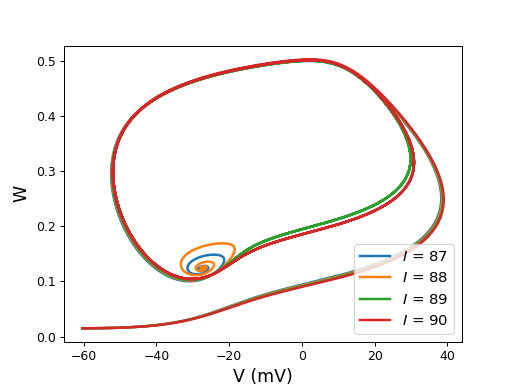

Text(0, 0.5, 'W')

In [13]:
SteadyCurrent=87

plt.figure()

for n in range(4):
    ML_params2['I']=np.array(SteadyCurrent+n)
    [time, data, data_V, data_W] = ML_sim(local_model = MorrisLecarMod(**ML_params2),
                                          dt=0.1, stimulus_amp=0, sim_length=500,
                                          V_Init=V_rest,
                                          W_Init=W_rest)
    plt.plot(data_V, data_W,label=f'$I$ = {SteadyCurrent+n}',linewidth=2)
    plt.legend(loc='best',fontsize=12)
    
plt.xlabel('V (mV)',fontsize=14)
plt.ylabel("W",fontsize=14)  

#### Plot showing the limit cycle and the oscillation emerged due to the steady current.

$I=90$

<IPython.core.display.Javascript object>


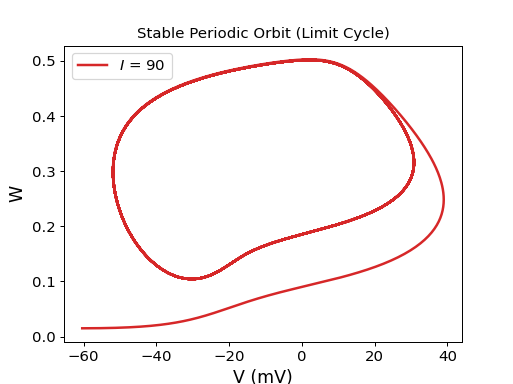

<IPython.core.display.Javascript object>


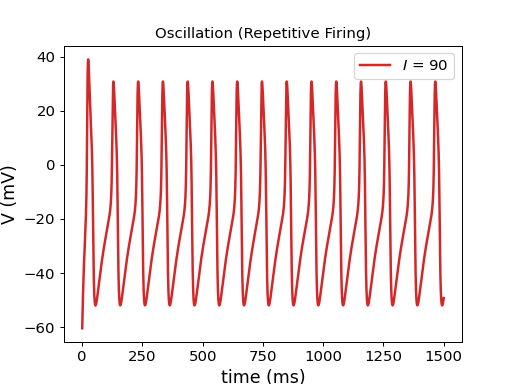

In [14]:
ML_params2['I']=np.array([90])
[time, data, data_V, data_W] = ML_sim(local_model = MorrisLecarMod(**ML_params2), 
                                      dt=0.1, stimulus_amp=0, sim_length=1500, 
                                      V_Init=V_rest,
                                      W_Init=W_rest)


fig, ax = plt.subplots()
ax.plot(data_V, data_W, linewidth=2,color='tab:red',label=f'$I$ = {90}')
plt.title('Stable Periodic Orbit (Limit Cycle)')
ax.set_xlabel('V (mV)',fontsize=14)
ax.set_ylabel("W",fontsize=14)
ax.tick_params(axis="x", labelsize=12) 
ax.tick_params(axis="y", labelsize=12)
ax.legend(loc='best',fontsize=12)

fig, ax = plt.subplots()
ax.plot(time,data_V, color='tab:red',label=f'$I$ = {90}', linewidth=2)
plt.title("Oscillation (Repetitive Firing)")
ax.set_xlabel('time (ms)', fontsize=14)
ax.set_ylabel("V (mV)", fontsize=14)
ax.tick_params(axis="x", labelsize=12) 
ax.tick_params(axis="y", labelsize=12)
ax.legend(loc='best',fontsize=12)

plt.show()

## 4. Bistability

For a range of $I$ values between the turning point (knee) and the Hopf bifurcation the model exhibits bistability: a stable oscillation and a stable steady state coexist. At $I=90$ the system is bistable. (cf. Rinzel & Ermentrout, 1998).


####  Find the stable steady state of the model with $I=90$

We have already observed stable oscillation in section 3; now we need to find the stable fixed point to illustrate the bistability of the model.
With the phase plane we find the stable fixed point, which corresponds to the intersection of the two nullclines. The rest state is then around $V≃-27$ and $N≃0.13$. We use these approximate values, close to the rest state, to run simulations that will tend to the precise values of the fixed point attractor.

We can see the bistable behaviour of the model by interacting with the phase plane: if we click (initial conditions) near the intersection of the nullclines we get a trajectory tending to a fixed point while if we click away from it we get a periodic orbit.


<IPython.core.display.Javascript object>


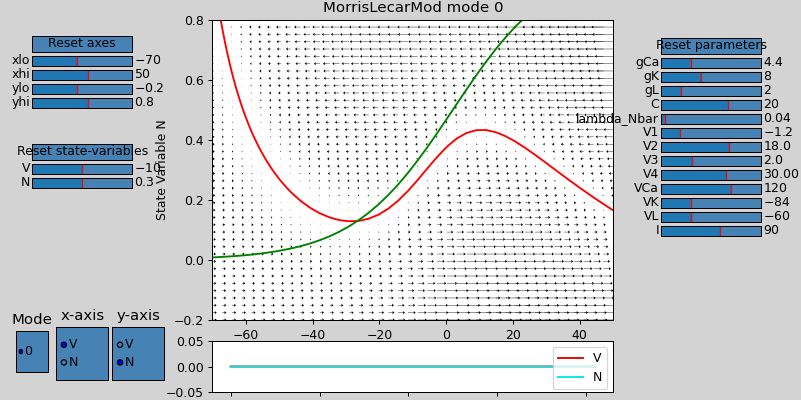

In [15]:
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive

ML_params2['I']=np.array([90])
ppi_fig = PhasePlaneInteractive(model=MorrisLecarMod(**ML_params2),
                                integrator=integrators.RungeKutta4thOrderDeterministic(dt=0.1))

ppi_fig.show()

#### Obtain the values of the rest state

We run the simulation with the values obtained from the phase plan as initial conditions for the model.

In [16]:
[time, data, data_V, data_W] = ML_sim(local_model = MorrisLecarMod(**ML_params2),
                                      stimulus_amp=0, dt=0.1, sim_length=3000,
                                      V_Init=-27,
                                      W_Init=0.13)

#### Plot showing the rest state and the corresponding V and N values.

The plots show the small and short oscillation that leads the model to converge in the rest state.

<IPython.core.display.Javascript object>


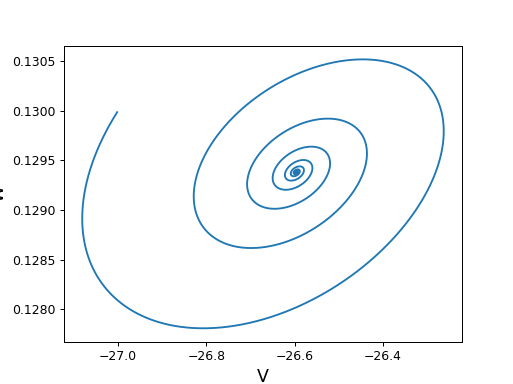

<IPython.core.display.Javascript object>


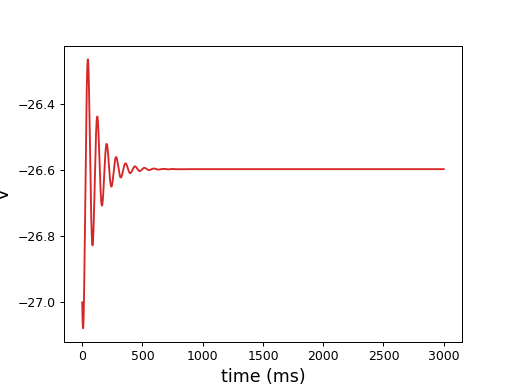

V_rest=-26.59686696969876; W_rest=0.1293793233592434


In [17]:
plt.figure()
plt.plot(data_V, data_W)
plt.xlabel('V', fontsize=14)
plt.ylabel("W", fontsize=14)

plt.figure()
plt.plot(time,data_V, color='tab:red')
plt.xlabel('time (ms)', fontsize=14)
plt.ylabel("V", fontsize=14)

print('\033[1m' + f'V_rest={data_V[-1]}; W_rest={data_W[-1]}' + '\033[0m')

#### Set the voltage and recovery to the rest state
We set the initial conditions to match the values at the rest state we have just found.
Then we run a simulation to see if the rest state values are correct.




In [18]:
V_rest2=data_V[-1]
W_rest2=data_W[-1]

<IPython.core.display.Javascript object>


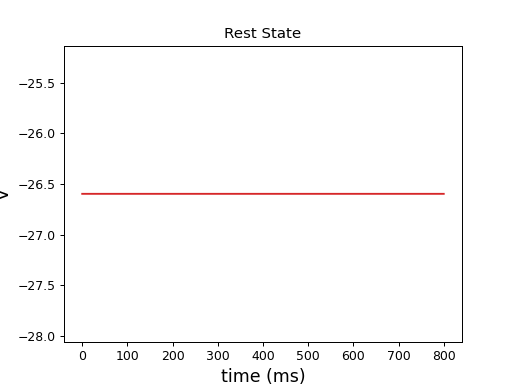

Text(0, 0.5, 'V')

In [19]:
[time, data, data_V, data_N] = ML_sim(local_model = MorrisLecarMod(**ML_params2),
                                              dt=0.1, sim_length=800, 
                                              V_Init=V_rest2,
                                              W_Init=W_rest2)
plt.figure()
plt.plot(time,data_V, color='tab:red')
plt.title("Rest State")
plt.xlabel('time (ms)', fontsize=14)
plt.ylabel("V", fontsize=14)


#### A brief pulse applied at the appropriate time can switch the system from firing to resting and back.

"A brief current pulse, whose phase and amplitude are in appropriate range, can switch the system out of the oscillatory response back to the rest state" (Rinzel & Ermentrout, 1998). 
We run a simulation with two stimuli (lasting 5 ms) of $amp=1.5$ at $t=100$ ms and $t=470$ ms (stimulus_onset+stimulus_T). The first pulse switches the membrane from rest to repetitive firing, while the second pushes the membrane back to rest. Also in the second plot we can see how the stimulus pushes the system out of the fixed point towards the periodic solution and then back.

There are two stable states: a stable fixed point (SPF) and a stable periodic orbit (SPO) separated by an unstable periodic orbit (UPO). "Initial values inside the unstable orbit tend to the attracting steady state, while initial condition outside of it will lead to the limit cycle of repetitive firing (Rinzel & Ermentrout, 1998).

<IPython.core.display.Javascript object>


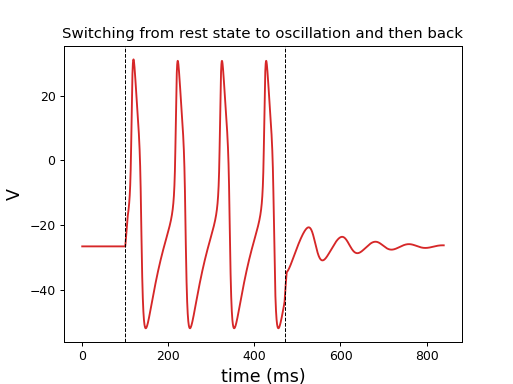

<IPython.core.display.Javascript object>


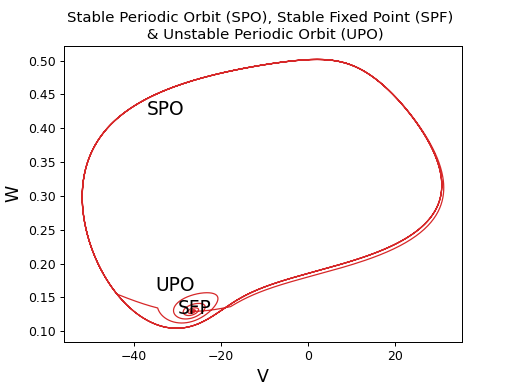

Text(0, 0.5, 'W')

In [21]:
ML_params2['I']=np.array([90])
[time, data, data_V, data_N] = ML_sim(local_model = MorrisLecarMod(**ML_params2),
                                              stimulus_amp=1.5, stimulus_onset=100, stimulus_T=370,
                                              stimulus_tau=5, dt=0.1, sim_length=840,
                                              V_Init=V_rest2,
                                              W_Init=W_rest2)


<IPython.core.display.Javascript object>


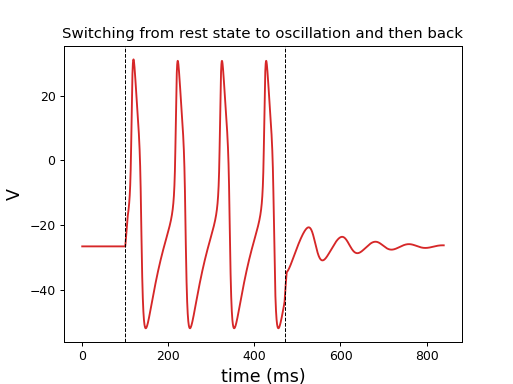

<IPython.core.display.Javascript object>


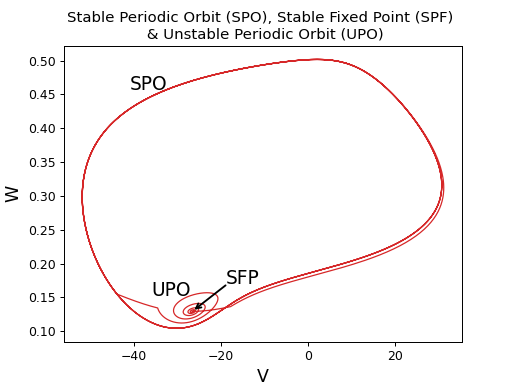

Text(0, 0.5, 'W')

In [58]:
plt.figure()
plt.plot(time,data_V, color='tab:red')
plt.axvline(x=100.1, color='k',linestyle='--', linewidth=0.8)
plt.axvline(x=470.1, color='k',linestyle='--', linewidth=0.8)
plt.title("Switching from rest state to oscillation and then back")
plt.xlabel('time (ms)', fontsize=14)
plt.ylabel("V", fontsize=14)

plt.figure()
plt.plot(data_V, data_N, linewidth=1, color='tab:red')
plt.title('Stable Periodic Orbit (SPO), Stable Fixed Point (SPF) \n & Unstable Periodic Orbit (UPO)')
#plt.text(-37, 0.42, 'SPO',fontsize=15)
#plt.text(-32, 0.16,'UPO',fontsize=15)
#plt.text(-30, 0.125, 'SFP',fontsize=15)
plt.text(-41, 0.456, 'SPO',fontsize=15)
plt.text(-36, 0.152,'UPO',fontsize=15)
plt.text(-19, 0.17, 'SFP',fontsize=15)
plt.annotate('', xy=(-18.5, 0.17),
             xytext=(data_V[0], data_N[0]),
             arrowprops=dict(arrowstyle= '<-',
                             color='k',
                             lw=1.5,
                             ls='-'))

plt.xlabel('V', fontsize=14)
plt.ylabel("W", fontsize=14)

### References
Morris, C. and Lecar, H. (1981) Voltage oscillations in the barnacle giant muscle fiber. Biophys. J. 35: 193 - 213. 

Rinzel, J. and Ermentrout, B. (1998) Analysis of neural excitability and oscillations. Pages 251-292 in C. Koch and I. Segev (eds.) Methods of Neuronal Modeling, MIT Press, Cambridge.